In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import time

from sklearn import preprocessing, linear_model, ensemble, svm, tree
from sklearn.utils import resample

from sklearn.model_selection import cross_val_score, train_test_split, ParameterGrid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_auc_score

In [2]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.loc[df.loc[df.tenure == 0].TotalCharges.index, 'TotalCharges'] = df.loc[df.tenure == 0].MonthlyCharges
df.TotalCharges = df.TotalCharges.astype(float)

In [5]:
df_majority = df[df.Churn=='No']
df_minority = df[df.Churn=='Yes']
 
df_minority_upsampled = resample(df_minority, 
                                 replace=True,
                                 n_samples=len(df_majority))

df_upsampled = pd.concat([df_majority, df_minority_upsampled])

df_upsampled.Churn.value_counts()

No     5174
Yes    5174
Name: Churn, dtype: int64

In [6]:
def features(df):
    X = df.drop(columns=['customerID', 'Churn'])
    X = pd.get_dummies(X, drop_first=True)
    y = pd.get_dummies(df.Churn, drop_first=True, prefix='Churn')

    #sns.heatmap(X.corr());
    
    X = X.drop(columns=['MultipleLines_No phone service', 'OnlineSecurity_No internet service',
                'OnlineBackup_No internet service', 'DeviceProtection_No internet service', 
                'TechSupport_No internet service', 'StreamingTV_No internet service', 
                'StreamingMovies_No internet service'])
    
    #sns.heatmap(X.corr());
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    scaler = preprocessing.MinMaxScaler()
    X_train[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(X_train[['tenure', 'MonthlyCharges', 'TotalCharges']])
    X_test[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.transform(X_test[['tenure', 'MonthlyCharges', 'TotalCharges']])
    
    return [X_train, X_test, y_train, y_test]

In [7]:
X_train, X_test, y_train, y_test = features(df)
X_train_upsampled, X_test_upsampled, y_train_upsampled, y_test_upsampled = features(df_upsampled)

C:\Users\Val\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\Val\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Val\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Val\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWar

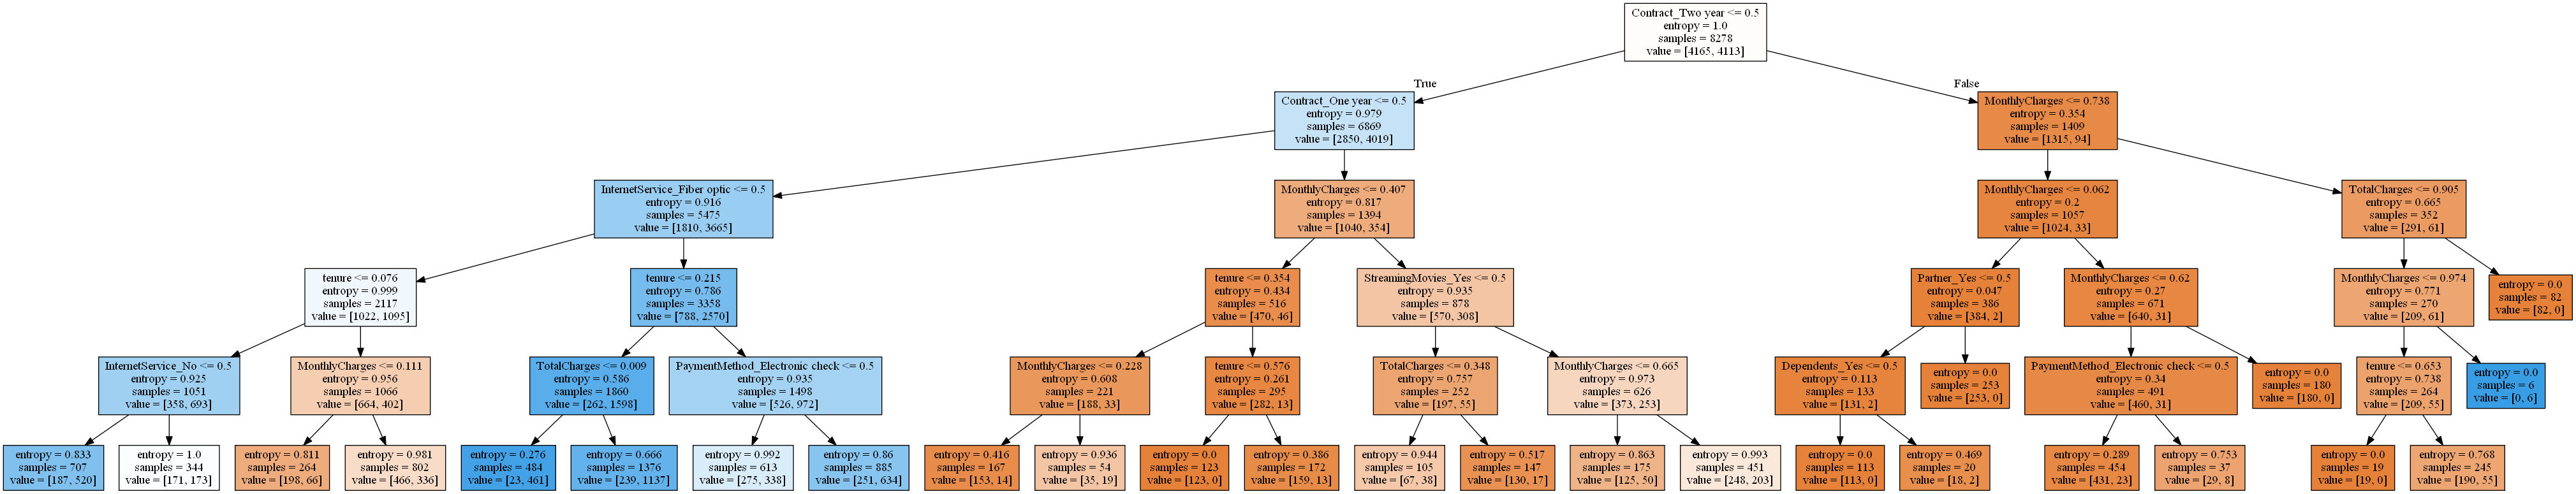

In [25]:
from IPython.display import Image
import pydotplus
import graphviz

decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    #max_features=2,
    max_depth=5,
)
decision_tree.fit(X_train_upsampled, y_train_upsampled)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X_train.columns,
    #class_names=['No Churn', 'Churn'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [8]:
classifiers = {'knn' : KNeighborsClassifier, 
               'forest' : ensemble.RandomForestClassifier,
               'logregr' : linear_model.LogisticRegression,
               'ridge' : linear_model.RidgeClassifier,
               'svc' : svm.SVC,
               'boosting' : ensemble.GradientBoostingClassifier
              }

In [9]:
clf_grid = {'knn' : {'n_neighbors' : [1, 5, 10, 25], 
                     'weights' : ['uniform', 'distance'],
                     'algorithm' : ['ball_tree', 'kd_tree', 'brute']},
            'forest' : {'n_estimators' : [100, 500, 1000],
                        'criterion' : ['gini', 'entropy'], 
                        'max_depth' : [2, 5, 10]},
            'logregr' : {'penalty' : ['l1', 'l2'], 
                         'tol' : [1e-3, 1e-4, 1e-5], 
                         'C' : [1, 1e-2, 1e-4], 
                         'solver' : ['liblinear']},
            'ridge' : {'alpha' : [1, 100, 1000], 
                       'tol' : [1e-3, 1e-4, 1e-5], 
                       'solver' : ['svd', 'cholesky', 'lsqr']}, #, ‘sparse_cg’, ‘sag’, ‘saga’,
            'svc' : {'C' : [1, 1e-2, 1e-3], 
                     'kernel' : ['linear', 'poly', 'rbf'], 
                     'gamma' : ['auto']},
            'boosting' : {'n_estimators': [100, 500, 1000],
                          'max_depth': [2, 3, 4],
                          'loss': ['deviance', 'exponential'],
                          'subsample' : [0.4, 0.8, 1]}
           }

In [10]:
def grid_search(X_train, X_test, y_train, y_test):
    results = pd.DataFrame()
    for method in classifiers.keys():
        classifier, parameters = classifiers[method](), clf_grid[method]
        for parameter_set in ParameterGrid(parameters):
            start_time = time.time()
            print('{} {}'.format(method, list(parameter_set.values())[:]))
            
            classifier.set_params(**parameter_set)
            classifier.fit(X_train, y_train.values.ravel())
            y_pred = classifier.predict(X_test)
            
            if (method == 'ridge') or (method == 'svc'):
                #d = classifier.decision_function(X_test)[0]
                #y_prob = np.exp(d) / np.sum(np.exp(d))
                Auroc = 0.5
            else:
                y_prob = classifier.predict_proba(X_test)[:,1] #More expensive
                Auroc = roc_auc_score(y_test, y_prob) #More expensive
        
            Accuracy = accuracy_score(y_test, y_pred)
            Precision = precision_score(y_test, y_pred)
            Recall = recall_score(y_test, y_pred)
        
            df2 = pd.DataFrame([(method, parameter_set.values(), Accuracy, Precision, Recall, Auroc)], 
                           columns = ['Method' , 'Parameters', 'Accuracy', 'Precision' , 'Recall', 'Auroc'])
            results = results.append(df2, ignore_index=True)
            
            total_time = time.time() - start_time
            print('Done in {} seconds'.format(total_time))
        
    return results

In [14]:
results =  grid_search(X_train, X_test, y_train, y_test)

knn ['ball_tree', 1, 'uniform']
Done in 0.5106337070465088 seconds
knn ['ball_tree', 1, 'distance']
Done in 0.5326688289642334 seconds
knn ['ball_tree', 5, 'uniform']
Done in 0.6210806369781494 seconds
knn ['ball_tree', 5, 'distance']
Done in 0.5774867534637451 seconds
knn ['ball_tree', 10, 'uniform']
Done in 0.631443977355957 seconds
knn ['ball_tree', 10, 'distance']
Done in 0.6624741554260254 seconds
knn ['ball_tree', 25, 'uniform']
Done in 0.9496424198150635 seconds
knn ['ball_tree', 25, 'distance']
Done in 0.9680206775665283 seconds
knn ['kd_tree', 1, 'uniform']
Done in 0.5473084449768066 seconds
knn ['kd_tree', 1, 'distance']
Done in 0.4283740520477295 seconds
knn ['kd_tree', 5, 'uniform']
Done in 0.6019210815429688 seconds
knn ['kd_tree', 5, 'distance']
Done in 0.6627624034881592 seconds
knn ['kd_tree', 10, 'uniform']
Done in 0.7839045524597168 seconds
knn ['kd_tree', 10, 'distance']
Done in 0.8902604579925537 seconds
knn ['kd_tree', 25, 'uniform']
Done in 1.025780200958252 secon

C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done in 2.474330186843872 seconds
forest ['entropy', 5, 100]
Done in 0.432830810546875 seconds
forest ['entropy', 5, 500]
Done in 1.8165900707244873 seconds
forest ['entropy', 5, 1000]
Done in 3.4982211589813232 seconds
forest ['entropy', 10, 100]
Done in 0.5435278415679932 seconds
forest ['entropy', 10, 500]
Done in 3.144319534301758 seconds
forest ['entropy', 10, 1000]
Done in 7.342013597488403 seconds
logregr [1, 'l1', 'liblinear', 0.001]
Done in 0.03690171241760254 seconds
logregr [1, 'l1', 'liblinear', 0.0001]
Done in 0.05884265899658203 seconds
logregr [1, 'l1', 'liblinear', 1e-05]
Done in 0.06781935691833496 seconds
logregr [1, 'l2', 'liblinear', 0.001]
Done in 0.026453733444213867 seconds
logregr [1, 'l2', 'liblinear', 0.0001]
Done in 0.03490638732910156 seconds
logregr [1, 'l2', 'liblinear', 1e-05]
Done in 0.04886794090270996 seconds
logregr [0.01, 'l1', 'liblinear', 0.001]
Done in 0.016955137252807617 seconds
logregr [0.01, 'l1', 'liblinear', 0.0001]
Done in 0.027924776077270

C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMe

Done in 0.01595783233642578 seconds
logregr [0.0001, 'l1', 'liblinear', 0.0001]
Done in 0.012965917587280273 seconds
logregr [0.0001, 'l1', 'liblinear', 1e-05]
Done in 0.011968135833740234 seconds
logregr [0.0001, 'l2', 'liblinear', 0.001]
Done in 0.01296544075012207 seconds
logregr [0.0001, 'l2', 'liblinear', 0.0001]
Done in 0.013962745666503906 seconds
logregr [0.0001, 'l2', 'liblinear', 1e-05]
Done in 0.013962745666503906 seconds
ridge [1, 'svd', 0.001]
Done in 0.014959335327148438 seconds
ridge [1, 'svd', 0.0001]
Done in 0.010970354080200195 seconds
ridge [1, 'svd', 1e-05]
Done in 0.009973764419555664 seconds
ridge [1, 'cholesky', 0.001]
Done in 0.00797891616821289 seconds
ridge [1, 'cholesky', 0.0001]
Done in 0.009972572326660156 seconds
ridge [1, 'cholesky', 1e-05]
Done in 0.00997304916381836 seconds
ridge [1, 'lsqr', 0.001]
Done in 0.010971784591674805 seconds
ridge [1, 'lsqr', 0.0001]
Done in 0.010970592498779297 seconds
ridge [1, 'lsqr', 1e-05]
Done in 0.012966394424438477 sec

C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done in 0.8412325382232666 seconds
svc [0.01, 'auto', 'rbf']


C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done in 1.1180195808410645 seconds
svc [0.001, 'auto', 'linear']


C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done in 0.703336238861084 seconds
svc [0.001, 'auto', 'poly']


C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done in 0.7581214904785156 seconds
svc [0.001, 'auto', 'rbf']


C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done in 1.1695191860198975 seconds
boosting ['deviance', 2, 100, 0.4]
Done in 0.4992101192474365 seconds
boosting ['deviance', 2, 100, 0.8]
Done in 0.416367769241333 seconds
boosting ['deviance', 2, 100, 1]
Done in 0.37918663024902344 seconds
boosting ['deviance', 2, 500, 0.4]
Done in 1.9411180019378662 seconds
boosting ['deviance', 2, 500, 0.8]
Done in 1.994776964187622 seconds
boosting ['deviance', 2, 500, 1]
Done in 1.7023284435272217 seconds
boosting ['deviance', 2, 1000, 0.4]
Done in 4.036344766616821 seconds
boosting ['deviance', 2, 1000, 0.8]
Done in 4.291393280029297 seconds
boosting ['deviance', 2, 1000, 1]
Done in 4.2030088901519775 seconds
boosting ['deviance', 3, 100, 0.4]
Done in 0.6871621608734131 seconds
boosting ['deviance', 3, 100, 0.8]
Done in 0.7341785430908203 seconds
boosting ['deviance', 3, 100, 1]
Done in 0.6897163391113281 seconds
boosting ['deviance', 3, 500, 0.4]
Done in 3.0828795433044434 seconds
boosting ['deviance', 3, 500, 0.8]
Done in 3.2928130626678467 s

In [15]:
results.sort_values(by='Recall', ascending=False)

,Method,Parameters,Accuracy,Precision,Recall,Auroc
22,knn,"(brute, 25, uniform)",0.790632,0.617647,0.560000,0.827700
6,knn,"(ball_tree, 25, uniform)",0.791341,0.619469,0.560000,0.828187
14,knn,"(kd_tree, 25, uniform)",0.790632,0.617647,0.560000,0.827792
45,logregr,"(1, l2, liblinear, 0.001)",0.812633,0.685619,0.546667,0.843537
46,logregr,"(1, l2, liblinear, 0.0001)",0.812633,0.685619,0.546667,0.843511
47,logregr,"(1, l2, liblinear, 1e-05)",0.812633,0.685619,0.546667,0.843506
42,logregr,"(1, l1, liblinear, 0.001)",0.812633,0.685619,0.546667,0.844117
43,logregr,"(1, l1, liblinear, 0.0001)",0.812633,0.686869,0.544000,0.844210
115,boosting,"(deviance, 4, 100, 0.8)",0.805536,0.664495,0.544000,0.845685
44,logregr,"(1, l1, liblinear, 1e-05)",0.812633,0.686869,0.544000,0.844208


In [11]:
results_upsampled = grid_search(X_train_upsampled, X_test_upsampled, y_train_upsampled, y_test_upsampled)

knn ['ball_tree', 1, 'uniform']
Done in 1.160871982574463 seconds
knn ['ball_tree', 1, 'distance']
Done in 1.0920557975769043 seconds
knn ['ball_tree', 5, 'uniform']
Done in 1.2545647621154785 seconds
knn ['ball_tree', 5, 'distance']
Done in 1.508866310119629 seconds
knn ['ball_tree', 10, 'uniform']
Done in 1.872234582901001 seconds
knn ['ball_tree', 10, 'distance']
Done in 1.4506735801696777 seconds
knn ['ball_tree', 25, 'uniform']
Done in 1.757218837738037 seconds
knn ['ball_tree', 25, 'distance']
Done in 1.6378891468048096 seconds
knn ['kd_tree', 1, 'uniform']
Done in 0.7584972381591797 seconds
knn ['kd_tree', 1, 'distance']
Done in 0.8003795146942139 seconds
knn ['kd_tree', 5, 'uniform']
Done in 1.623643159866333 seconds
knn ['kd_tree', 5, 'distance']
Done in 1.3051872253417969 seconds
knn ['kd_tree', 10, 'uniform']
Done in 1.3590404987335205 seconds
knn ['kd_tree', 10, 'distance']
Done in 1.4098904132843018 seconds
knn ['kd_tree', 25, 'uniform']
Done in 1.6650376319885254 seconds


C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done in 0.023936033248901367 seconds
ridge [1, 'svd', 0.0001]
Done in 0.025930404663085938 seconds
ridge [1, 'svd', 1e-05]
Done in 0.01795196533203125 seconds
ridge [1, 'cholesky', 0.001]
Done in 0.011968135833740234 seconds
ridge [1, 'cholesky', 0.0001]
Done in 0.021941184997558594 seconds
ridge [1, 'cholesky', 1e-05]
Done in 0.01595783233642578 seconds
ridge [1, 'lsqr', 0.001]
Done in 0.018948793411254883 seconds
ridge [1, 'lsqr', 0.0001]
Done in 0.07679510116577148 seconds
ridge [1, 'lsqr', 1e-05]
Done in 0.1077115535736084 seconds
ridge [100, 'svd', 0.001]
Done in 0.01795196533203125 seconds
ridge [100, 'svd', 0.0001]
Done in 0.018949270248413086 seconds
ridge [100, 'svd', 1e-05]
Done in 0.020945072174072266 seconds
ridge [100, 'cholesky', 0.001]
Done in 0.014959335327148438 seconds
ridge [100, 'cholesky', 0.0001]
Done in 0.012964725494384766 seconds
ridge [100, 'cholesky', 1e-05]
Done in 0.01296544075012207 seconds
ridge [100, 'lsqr', 0.001]
Done in 0.013963460922241211 seconds
ri

C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done in 3.552029848098755 seconds
svc [0.01, 'auto', 'rbf']
Done in 4.337958812713623 seconds
svc [0.001, 'auto', 'linear']
Done in 2.6265673637390137 seconds
svc [0.001, 'auto', 'poly']


C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done in 3.934347629547119 seconds
svc [0.001, 'auto', 'rbf']


C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done in 5.351426601409912 seconds
boosting ['deviance', 2, 100, 0.4]
Done in 0.8347668647766113 seconds
boosting ['deviance', 2, 100, 0.8]
Done in 0.8532540798187256 seconds
boosting ['deviance', 2, 100, 1]
Done in 0.5679891109466553 seconds
boosting ['deviance', 2, 500, 0.4]
Done in 3.5497262477874756 seconds
boosting ['deviance', 2, 500, 0.8]
Done in 3.270433187484741 seconds
boosting ['deviance', 2, 500, 1]
Done in 2.490351915359497 seconds
boosting ['deviance', 2, 1000, 0.4]
Done in 6.160672664642334 seconds
boosting ['deviance', 2, 1000, 0.8]
Done in 6.372716426849365 seconds
boosting ['deviance', 2, 1000, 1]
Done in 4.863413572311401 seconds
boosting ['deviance', 3, 100, 0.4]
Done in 0.8248989582061768 seconds
boosting ['deviance', 3, 100, 0.8]
Done in 0.9567537307739258 seconds
boosting ['deviance', 3, 100, 1]
Done in 0.8582496643066406 seconds
boosting ['deviance', 3, 500, 0.4]
Done in 4.14345383644104 seconds
boosting ['deviance', 3, 500, 0.8]
Done in 4.5032923221588135 second

,Method,Parameters,Accuracy,Precision,Recall,Auroc
15,knn,"(kd_tree, 25, distance)",0.827053,0.758646,0.971725,0.971064
23,knn,"(brute, 25, distance)",0.827053,0.758646,0.971725,0.971061
7,knn,"(ball_tree, 25, distance)",0.827536,0.759205,0.971725,0.971073
21,knn,"(brute, 10, distance)",0.833333,0.769578,0.963242,0.958398
5,knn,"(ball_tree, 10, distance)",0.833333,0.769578,0.963242,0.958411
13,knn,"(kd_tree, 10, distance)",0.833333,0.769578,0.963242,0.958416
11,knn,"(kd_tree, 5, distance)",0.830918,0.769932,0.955702,0.931587
3,knn,"(ball_tree, 5, distance)",0.830918,0.769932,0.955702,0.931587
19,knn,"(brute, 5, distance)",0.830918,0.769932,0.955702,0.931636
1,knn,"(ball_tree, 1, distance)",0.864734,0.816194,0.950047,0.862536


In [27]:
results_upsampled.sort_values(by='Accuracy', ascending=False)

,Method,Parameters,Accuracy,Precision,Recall,Auroc
121,boosting,"(deviance, 4, 1000, 0.8)",0.892271,0.862457,0.939680,0.946434
120,boosting,"(deviance, 4, 1000, 0.4)",0.889855,0.858742,0.939680,0.935186
122,boosting,"(deviance, 4, 1000, 1)",0.885990,0.852263,0.940622,0.945381
148,boosting,"(exponential, 4, 1000, 0.8)",0.882609,0.856894,0.925542,0.941867
149,boosting,"(exponential, 4, 1000, 1)",0.874396,0.846753,0.921772,0.938102
9,knn,"(kd_tree, 1, distance)",0.864734,0.816194,0.950047,0.862536
1,knn,"(ball_tree, 1, distance)",0.864734,0.816194,0.950047,0.862536
17,knn,"(brute, 1, distance)",0.864734,0.816707,0.949105,0.862560
16,knn,"(brute, 1, uniform)",0.864734,0.816707,0.949105,0.862560
0,knn,"(ball_tree, 1, uniform)",0.864734,0.816194,0.950047,0.862536
